# Modelo de Joint Fusion

Consiste en crear un nuevo modelo conformado por la unión de los modelos individuales, concatenando las neuronas de las capas de salida completamente conectadas para usar ambas representaciones de la información en el entrenamiento (Espectrogramas y Atractores)

In [ ]:
# Cargar repositorio
!git clone https://github.com/Diego99021999/Proyecto_Deep_Learning_Diego_Lopez

fatal: destination path 'Proyecto_Deep_Learning_Diego_Lopez' already exists and is not an empty directory.


In [ ]:
def normalize(images):
  norm = np.abs(images)
  norm -= norm.min()
  norm = norm/norm.max()
  return norm

def get_images(filenames, labels):

  all_images = []
  all_labels = []

  for (i, file) in enumerate(filenames):
    with open(file, 'rb') as f:
      lista = pickle.load(f)

    all_images += lista
    all_labels.append(labels[i]*np.ones(len(lista)))

  return normalize(np.expand_dims(np.array(all_images), axis = 3)), normalize(np.hstack(all_labels))

## Modelo base para espectrogramas

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Concatenate, MaxPooling2D, Flatten, Dense, GlobalMaxPooling1D, subtract, BatchNormalization
from tensorflow.keras.models import Model, clone_model, load_model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf


# Modelo base espectrogramas
input_shape_e = (128, 91, 1) #

# capas convolucionales
sig_input_e = Input(input_shape_e)


cnn1_e = Conv2D(16, (3, 3), activation='relu', input_shape=input_shape_e)(sig_input_e)
mp1_e = MaxPooling2D((3,3))(cnn1_e)
mp1_e = BatchNormalization()(mp1_e)
cnn2_e = Conv2D(16,(3,3),activation='relu')(mp1_e)
mp2_e = MaxPooling2D((2,2))(cnn2_e)
mp2_e = BatchNormalization()(mp2_e)
cnn3_e = Conv2D(32,(3,3),activation='relu')(mp2_e)

# Capas completamente conectadas
flat_e = Flatten()(cnn3_e)
embed_e = Dense(64, activation='relu')(flat_e)

conv_base_e = Model(sig_input_e, embed_e)

conv_base_e.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 91, 1)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 89, 16)       160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 42, 29, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 42, 29, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 40, 27, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 20, 13, 16)       0   

## Modelo base para atractores

In [ ]:
# Modelo base atractores
input_shape_a = (182, 182, 1) #

# capas convolucionales
sig_input_a = Input(input_shape_a)


cnn1_a = Conv2D(16, (3, 3), activation='relu', input_shape=input_shape_a)(sig_input_a)
mp1_a = MaxPooling2D((3,3))(cnn1_a)
mp1_a = BatchNormalization()(mp1_a)
cnn2_a = Conv2D(16,(3,3),activation='relu')(mp1_a)
mp2_a = MaxPooling2D((2,2))(cnn2_a)
mp2_a = BatchNormalization()(mp2_a)
cnn3_a = Conv2D(32,(3,3),activation='relu')(mp2_a)

# Capas completamente conectadas
flat_a = Flatten()(cnn3_a)
embed_a = Dense(64, activation='relu')(flat_a)

conv_base_a = Model(sig_input_a, embed_a)

conv_base_a.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 182, 182, 1)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 60, 60, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 60, 60, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 58, 58, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 29, 29, 16)       0   

In [ ]:
left_input_a = Input(input_shape_a)
right_input_e = Input(input_shape_e)

# encode each of the two inputs into a vector with the base conv model
encoded_a = conv_base_a(left_input_a)
encoded_e = conv_base_e(right_input_e)


fusion = Concatenate()([encoded_a,encoded_e]) # this can be any other fusion method too

prediction = Dense(1, activation='sigmoid')(fusion)

twin_net = Model([left_input_a,right_input_e],prediction)

optimizer = Adam(0.001)

twin_net.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

twin_net.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 182, 182, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 128, 91, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 model_4 (Functional)           (None, 64)           1500304     ['input_7[0][0]']                
                                                                                            

In [ ]:
import random
import pickle
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import random
random.seed(10)

## Cargar imagenes. Espectrogramas y atractores

In [ ]:
#Paths
ruta_e = "/content/Proyecto_Deep_Learning_Diego_Lopez/local/spectrograms"

# Get list of filenames
labels_e = []
files_e = [f for f in listdir(ruta_e) if (isfile(join(ruta_e, f)))]
files_e.sort()
for i in range(len(files_e)):
    files_e[i] = ruta_e + "/" + files_e[i]
    labels_e.append(0 if 'HC' in files_e[i] else 1)

labels_e = np.array(labels_e)
files_e = np.array(files_e)

In [ ]:
#Paths
ruta_a = "/content/Proyecto_Deep_Learning_Diego_Lopez/local/attractors"


# Get list of filenames
labels_a = []
files_a = [f for f in listdir(ruta_a) if (isfile(join(ruta_a, f)))]
files_a.sort()
for i in range(len(files_a)):
    files_a[i] = ruta_a + "/" + files_a[i]
    labels_a.append(0 if 'HC' in files_a[i] else 1)

labels_a = np.array(labels_a)
files_a = np.array(files_a)

## Entrenamiento y pruebas

Epoch 1/10
72/72 [==============================] - 6s 24ms/step - loss: 0.9108 - accuracy: 0.6443 - val_loss: 0.8059 - val_accuracy: 0.4501
Epoch 2/10
72/72 [==============================] - 1s 16ms/step - loss: 0.3842 - accuracy: 0.8339 - val_loss: 1.4374 - val_accuracy: 0.4501
Epoch 3/10
72/72 [==============================] - 1s 16ms/step - loss: 0.2583 - accuracy: 0.8906 - val_loss: 1.0997 - val_accuracy: 0.4501
Epoch 4/10
72/72 [==============================] - 1s 18ms/step - loss: 0.1604 - accuracy: 0.9494 - val_loss: 2.2279 - val_accuracy: 0.4501
Epoch 5/10
72/72 [==============================] - 1s 18ms/step - loss: 0.0927 - accuracy: 0.9730 - val_loss: 2.9200 - val_accuracy: 0.4501
Epoch 6/10
72/72 [==============================] - 1s 19ms/step - loss: 0.0446 - accuracy: 0.9900 - val_loss: 1.9441 - val_accuracy: 0.4709
Epoch 7/10
72/72 [==============================] - 1s 16ms/step - loss: 0.0172 - accuracy: 0.9996 - val_loss: 2.8760 - val_accuracy: 0.4590
Epoch 8/10
72

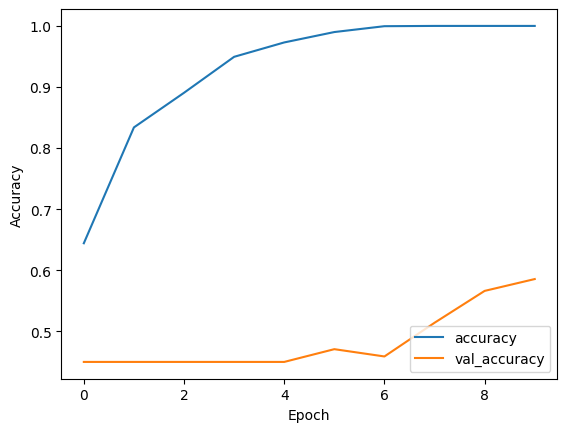

21/21 - 0s - loss: 1.4079 - accuracy: 0.5857 - 310ms/epoch - 15ms/step

______________________________________________
Epoch 1/10
76/76 [==============================] - 7s 22ms/step - loss: 0.8007 - accuracy: 0.6397 - val_loss: 0.6847 - val_accuracy: 0.5450
Epoch 2/10
76/76 [==============================] - 1s 17ms/step - loss: 0.3666 - accuracy: 0.8401 - val_loss: 0.6755 - val_accuracy: 0.6110
Epoch 3/10
76/76 [==============================] - 1s 15ms/step - loss: 0.1964 - accuracy: 0.9298 - val_loss: 0.7644 - val_accuracy: 0.4679
Epoch 4/10
76/76 [==============================] - 1s 15ms/step - loss: 0.1071 - accuracy: 0.9669 - val_loss: 1.2402 - val_accuracy: 0.4642
Epoch 5/10
76/76 [==============================] - 1s 15ms/step - loss: 0.0515 - accuracy: 0.9901 - val_loss: 1.9256 - val_accuracy: 0.4642
Epoch 6/10
76/76 [==============================] - 1s 15ms/step - loss: 0.0240 - accuracy: 0.9975 - val_loss: 3.6948 - val_accuracy: 0.4642
Epoch 7/10
76/76 [=================

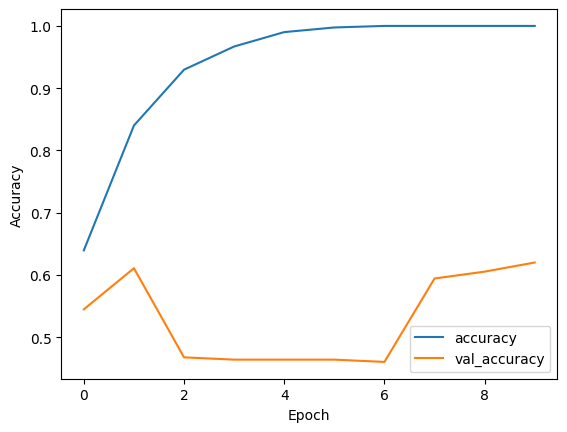

18/18 - 0s - loss: 1.6958 - accuracy: 0.6202 - 308ms/epoch - 17ms/step

______________________________________________
Epoch 1/10
75/75 [==============================] - 8s 24ms/step - loss: 0.9145 - accuracy: 0.5562 - val_loss: 0.7116 - val_accuracy: 0.4458
Epoch 2/10
75/75 [==============================] - 1s 17ms/step - loss: 0.5472 - accuracy: 0.7139 - val_loss: 0.7235 - val_accuracy: 0.4527
Epoch 3/10
75/75 [==============================] - 1s 16ms/step - loss: 0.4135 - accuracy: 0.8029 - val_loss: 0.9018 - val_accuracy: 0.4286
Epoch 4/10
75/75 [==============================] - 1s 17ms/step - loss: 0.3008 - accuracy: 0.8767 - val_loss: 0.7777 - val_accuracy: 0.4699
Epoch 5/10
75/75 [==============================] - 1s 16ms/step - loss: 0.1957 - accuracy: 0.9383 - val_loss: 0.9637 - val_accuracy: 0.4699
Epoch 6/10
75/75 [==============================] - 1s 18ms/step - loss: 0.1203 - accuracy: 0.9727 - val_loss: 0.8543 - val_accuracy: 0.5370
Epoch 7/10
75/75 [=================

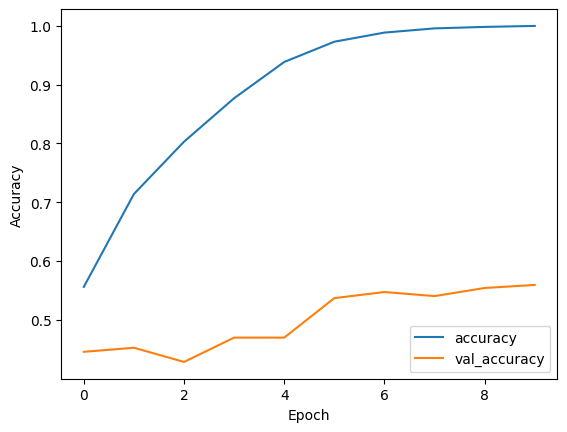

19/19 - 0s - loss: 1.8819 - accuracy: 0.5594 - 316ms/epoch - 17ms/step

______________________________________________
Epoch 1/10
70/70 [==============================] - 6s 29ms/step - loss: 0.8712 - accuracy: 0.6298 - val_loss: 0.6982 - val_accuracy: 0.4918
Epoch 2/10
70/70 [==============================] - 1s 19ms/step - loss: 0.3224 - accuracy: 0.8655 - val_loss: 0.7241 - val_accuracy: 0.4946
Epoch 3/10
70/70 [==============================] - 1s 16ms/step - loss: 0.1688 - accuracy: 0.9476 - val_loss: 0.8080 - val_accuracy: 0.4946
Epoch 4/10
70/70 [==============================] - 1s 16ms/step - loss: 0.0667 - accuracy: 0.9879 - val_loss: 1.4358 - val_accuracy: 0.4946
Epoch 5/10
70/70 [==============================] - 1s 17ms/step - loss: 0.0276 - accuracy: 0.9978 - val_loss: 1.4061 - val_accuracy: 0.4946
Epoch 6/10
70/70 [==============================] - 1s 17ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 1.4413 - val_accuracy: 0.4918
Epoch 7/10
70/70 [=================

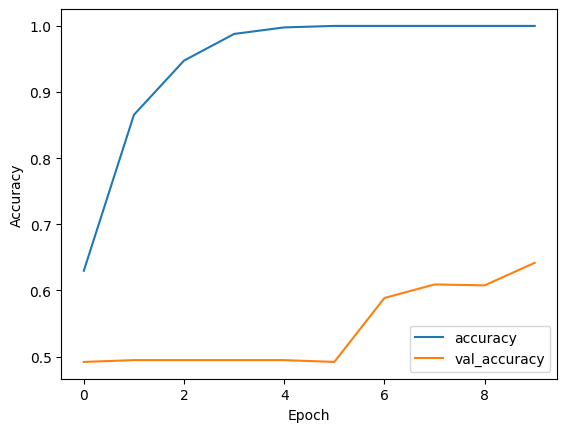

23/23 - 0s - loss: 1.2594 - accuracy: 0.6417 - 351ms/epoch - 15ms/step

______________________________________________
Epoch 1/10
80/80 [==============================] - 6s 26ms/step - loss: 0.8282 - accuracy: 0.6231 - val_loss: 0.6802 - val_accuracy: 0.5829
Epoch 2/10
80/80 [==============================] - 1s 16ms/step - loss: 0.4353 - accuracy: 0.7930 - val_loss: 1.1203 - val_accuracy: 0.5829
Epoch 3/10
80/80 [==============================] - 1s 15ms/step - loss: 0.2511 - accuracy: 0.9008 - val_loss: 1.8599 - val_accuracy: 0.5829
Epoch 4/10
80/80 [==============================] - 1s 17ms/step - loss: 0.1467 - accuracy: 0.9435 - val_loss: 0.7779 - val_accuracy: 0.5991
Epoch 5/10
80/80 [==============================] - 1s 15ms/step - loss: 0.0775 - accuracy: 0.9771 - val_loss: 1.3144 - val_accuracy: 0.5668
Epoch 6/10
80/80 [==============================] - 1s 15ms/step - loss: 0.0350 - accuracy: 0.9937 - val_loss: 0.9500 - val_accuracy: 0.5783
Epoch 7/10
80/80 [=================

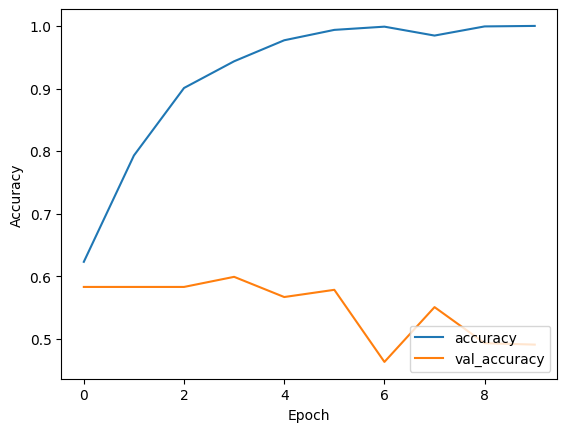

14/14 - 0s - loss: 0.7779 - accuracy: 0.5991 - 416ms/epoch - 30ms/step

______________________________________________


In [ ]:
# Definir splits 5-fold crossvalidation

skf = StratifiedKFold(n_splits=5)

all_preds = []
all_test = []
acc_test = []

for i, (train_index, test_index) in enumerate(skf.split(files_e, labels_e)):

  # Extraer imagenes y etiquetas Espectrogramas
  tr_images_e, tr_labels_e = get_images(files_e[train_index], labels_e[train_index])
  ts_images_e, ts_labels_e = get_images(files_e[test_index], labels_e[test_index])

  # Extraer imagenes y etiquetas Atractores
  tr_images_a, tr_labels_a = get_images(files_a[train_index], labels_a[train_index])
  ts_images_a, ts_labels_a = get_images(files_a[test_index], labels_a[test_index])

  # Callback
  filepath = './my_best_model.hdf5'
  checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_accuracy',
                                verbose=0,
                                save_best_only=True,
                                mode='max')
  callbacks = [checkpoint]

  # Entrenar Modelo
  optimizer = Adam(0.001)

  model_cloned = clone_model(twin_net)
  model_cloned.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  history = model_cloned.fit([tr_images_a, tr_images_e], tr_labels_e, epochs=10,
                              validation_data=([ts_images_a, ts_images_e], ts_labels_e),
                              callbacks=callbacks)

  model_cloned = load_model(filepath)
  all_preds.append(model_cloned.predict([ts_images_a, ts_images_e]))
  all_test.append(ts_labels_e)


  # Graficar historia de entrenamiento
  plt.figure()
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  test_loss, test_acc = model_cloned.evaluate([ts_images_a, ts_images_e],  ts_labels_e, verbose=2)
  acc_test.append(test_acc)
  print('\n______________________________________________')

In [ ]:
# Accuracy promedio
val = np.mean(acc_test)
val2 = np.std(acc_test)
print(f'El Accuracy de prueba promedio entre los 5 folds es de {val:.3} ± {val2:.3} ')

El Accuracy de prueba promedio entre los 5 folds es de 0.601 ± 0.0283 


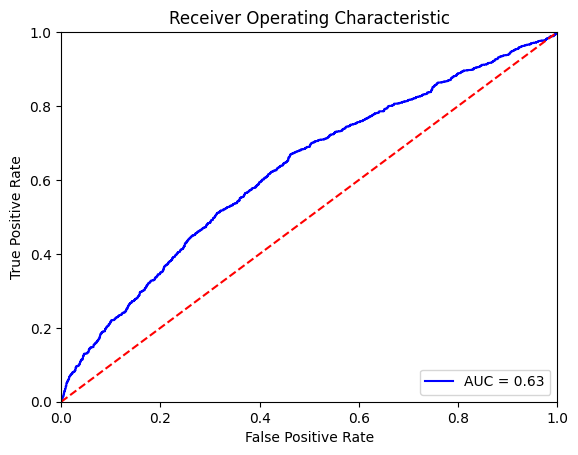

In [ ]:
import sklearn.metrics as metrics

#all_preds1 = np.round(np.vstack(all_preds))
all_preds1 = np.vstack(all_preds)
all_test1 = np.hstack(all_test)

fpr, tpr, threshold = metrics.roc_curve(all_test1, all_preds1)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()